# 利用Keras进行颜值打分


---


王兴睿 2017201690 ([github地址](https://github.com/XingruiWang/RUC-Deep-Learning-Course/blob/master/Homework/HW_3/%E7%8E%8B%E5%85%B4%E7%9D%BF_2017201690_DL_W03.ipynb))

### 一、任务描述

人的颜值直接由人脸的特征（五官比例、大小、皮肤等等）决定，因此人脸可以看作是决定性的影响因素。目前的数据集是已经标记好的人脸照片(X，**图片数据**)和颜值分数(y，**连续型数据**)，因此可以通过建立简单的**线性回归模型**拟合人脸和颜值的关系，实现对人脸颜值的打分。

### 二、数据读入与数据展示



*   数据读入与准备，X储存图片，y储存label



In [ ]:
import os
import pandas as pd
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow as tf
from keras import Model
from keras.layers import Dense,Flatten,Input
from keras.optimizers import SGD,RMSprop,Adam 
import matplotlib.pyplot as plt

# 数据目录和图片目录
dir = "/home/wxr/hw3/course7/data_facescore"
img_dir = "/home/wxr/hw3/course7/data_facescore/images"

# data是FaceScore.csv标签文件的表格形式。
# 之后标签存到变量y里，X_file记录图片的文件名，方便之后读取图片，
data = pd.read_csv(os.path.join(dir, 'FaceScore.csv'))
y = data["Rating"].to_numpy()
X_file = data["Filename"].to_numpy()

/home/wxr/anaconda3/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [ ]:
# X = np.array([cv.imread(os.path.join(img_dir, filename)) for filename in X_file])
# 这个包可以加载进度条
from tqdm import tqdm

# 读取图片
X = []
for filename in tqdm(X_file):
    X.append(cv.imread(os.path.join(img_dir, filename)))
X = np.array(X)

100%|██████████| 5500/5500 [00:11<00:00, 499.49it/s]




*   数据展示



先画出y的分布图，可以看到y（颜值）是从1到5的连续变量，呈现右偏分布。颜值处于在2-3之间的人脸很多。

(array([  17.,   71.,  412., 1500., 1278.,  761.,  602.,  469.,  325.,
          65.]),
 array([1.        , 1.38333333, 1.76666667, 2.15      , 2.53333333,
        2.91666667, 3.3       , 3.68333333, 4.06666667, 4.45      ,
        4.83333333]),
 <a list of 10 Patch objects>)

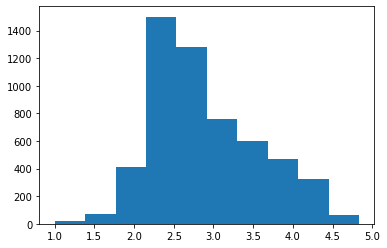

In [ ]:
plt.hist(y)

展示一下颜值最高的和颜值最低的，确实差距很明显

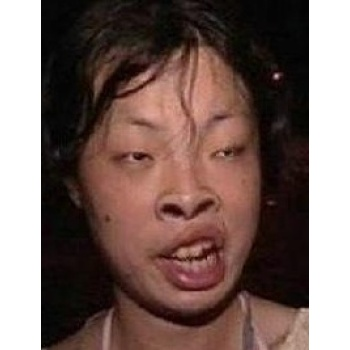

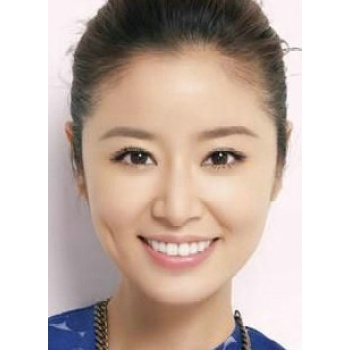

In [ ]:
cv2_imshow(X[np.where(y == min(y))[0][0]])
cv2_imshow(X[np.where(y == max(y))[0][0]])

### 三、建立以及训练模型

*  进行数据集和测试集的划分

In [ ]:
# Image.shpae = 350 * 350 * 3
# tf.debugging.set_log_device_placement(False)
N = 350
from sklearn.model_selection import train_test_split
X = X.astype(np.float32) / 255
y = y.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

*  建立线性模型

In [ ]:
input_layer = Input([N, N, 3])
x = input_layer
x = Flatten()(x)
x = Dense(1)(x)
output_layer = x
model=Model(input_layer, output_layer)
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 350, 350, 3)]     0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 367500)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 367501    
Total params: 367,501
Trainable params: 367,501
Non-trainable params: 0
_________________________________________________________________


*  因为是回归问题，所以loss选择mse, 并且采用Adam作为optimizer

In [ ]:
from keras.optimizers import Adam
model.compile(loss='mse',optimizer=Adam(lr=0.001),metrics=['mse'])

In [ ]:
from keras.callbacks import ModelCheckpoint

# 将测试集mse最小的模型保存到 weights.best.hdf5
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=64, epochs=200, 
                    callbacks=callbacks_list, verbose=1)

Epoch 1/200
59/61 [============================>.] - ETA: 0s - loss: 3656.5830 - mse: 3656.5830
Epoch 00001: val_mse improved from inf to 6.59165, saving model to weights.best.hdf5
61/61 [==============================] - 5s 75ms/step - loss: 3588.1758 - mse: 3588.1758 - val_loss: 6.5916 - val_mse: 6.5916
Epoch 2/200
59/61 [============================>.] - ETA: 0s - loss: 7.6016 - mse: 7.6016
Epoch 00002: val_mse improved from 6.59165 to 0.82803, saving model to weights.best.hdf5
61/61 [==============================] - 3s 51ms/step - loss: 7.4743 - mse: 7.4743 - val_loss: 0.8280 - val_mse: 0.8280
Epoch 3/200
60/61 [============================>.] - ETA: 0s - loss: 0.6565 - mse: 0.6565
Epoch 00003: val_mse improved from 0.82803 to 0.54112, saving model to weights.best.hdf5
61/61 [==============================] - 3s 55ms/step - loss: 0.6568 - mse: 0.6568 - val_loss: 0.5411 - val_mse: 0.5411
Epoch 4/200
61/61 [==============================] - ETA: 0s - loss: 0.4990 - mse: 0.4990
Epoch

Epoch 31/200
59/61 [============================>.] - ETA: 0s - loss: 1.6056 - mse: 1.6056
Epoch 00031: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 69ms/step - loss: 1.6738 - mse: 1.6738 - val_loss: 10.2615 - val_mse: 10.2615
Epoch 32/200
59/61 [============================>.] - ETA: 0s - loss: 2.4319 - mse: 2.4319
Epoch 00032: val_mse did not improve from 0.32298
61/61 [==============================] - 3s 51ms/step - loss: 2.3915 - mse: 2.3915 - val_loss: 0.5120 - val_mse: 0.5120
Epoch 33/200
59/61 [============================>.] - ETA: 0s - loss: 40.2554 - mse: 40.2554
Epoch 00033: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 63ms/step - loss: 43.7824 - mse: 43.7824 - val_loss: 218.1039 - val_mse: 218.1039
Epoch 34/200
59/61 [============================>.] - ETA: 0s - loss: 90.5497 - mse: 90.5497
Epoch 00034: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 70ms/step - loss: 89

Epoch 62/200
61/61 [==============================] - ETA: 0s - loss: 22.3659 - mse: 22.3659
Epoch 00062: val_mse did not improve from 0.32298
61/61 [==============================] - 3s 56ms/step - loss: 22.3659 - mse: 22.3659 - val_loss: 3.0774 - val_mse: 3.0774
Epoch 63/200
60/61 [============================>.] - ETA: 0s - loss: 63.7239 - mse: 63.7239
Epoch 00063: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 67ms/step - loss: 64.9653 - mse: 64.9653 - val_loss: 714.1967 - val_mse: 714.1967
Epoch 64/200
59/61 [============================>.] - ETA: 0s - loss: 66.1155 - mse: 66.1155
Epoch 00064: val_mse did not improve from 0.32298
61/61 [==============================] - 3s 52ms/step - loss: 64.8978 - mse: 64.8978 - val_loss: 1.5388 - val_mse: 1.5388
Epoch 65/200
60/61 [============================>.] - ETA: 0s - loss: 7.5785 - mse: 7.5785
Epoch 00065: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 59ms/step - loss

Epoch 93/200
60/61 [============================>.] - ETA: 0s - loss: 14.6790 - mse: 14.6790
Epoch 00093: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 58ms/step - loss: 14.6449 - mse: 14.6449 - val_loss: 1.5673 - val_mse: 1.5673
Epoch 94/200
60/61 [============================>.] - ETA: 0s - loss: 2.0346 - mse: 2.0346
Epoch 00094: val_mse did not improve from 0.32298
61/61 [==============================] - 3s 52ms/step - loss: 2.0507 - mse: 2.0507 - val_loss: 13.6252 - val_mse: 13.6252
Epoch 95/200
59/61 [============================>.] - ETA: 0s - loss: 8.8585 - mse: 8.8585
Epoch 00095: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 66ms/step - loss: 8.8035 - mse: 8.8035 - val_loss: 5.3294 - val_mse: 5.3294
Epoch 96/200
60/61 [============================>.] - ETA: 0s - loss: 42.2240 - mse: 42.2240
Epoch 00096: val_mse did not improve from 0.32298
61/61 [==============================] - 3s 52ms/step - loss: 42.528

Epoch 124/200
59/61 [============================>.] - ETA: 0s - loss: 14.5352 - mse: 14.5352
Epoch 00124: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 70ms/step - loss: 14.2901 - mse: 14.2901 - val_loss: 4.7248 - val_mse: 4.7248
Epoch 125/200
60/61 [============================>.] - ETA: 0s - loss: 8.4786 - mse: 8.4786
Epoch 00125: val_mse did not improve from 0.32298
61/61 [==============================] - 3s 52ms/step - loss: 8.4584 - mse: 8.4584 - val_loss: 1.5949 - val_mse: 1.5949
Epoch 126/200
61/61 [==============================] - ETA: 0s - loss: 153.6673 - mse: 153.6673
Epoch 00126: val_mse did not improve from 0.32298
61/61 [==============================] - 3s 56ms/step - loss: 153.6673 - mse: 153.6673 - val_loss: 27.4671 - val_mse: 27.4671
Epoch 127/200
59/61 [============================>.] - ETA: 0s - loss: 15.9453 - mse: 15.9453
Epoch 00127: val_mse did not improve from 0.32298
61/61 [==============================] - 5s 74ms/step - 

Epoch 155/200
61/61 [==============================] - ETA: 0s - loss: 2.9482 - mse: 2.9482
Epoch 00155: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 60ms/step - loss: 2.9482 - mse: 2.9482 - val_loss: 1.1224 - val_mse: 1.1224
Epoch 156/200
60/61 [============================>.] - ETA: 0s - loss: 15.9020 - mse: 15.9020
Epoch 00156: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 67ms/step - loss: 15.9754 - mse: 15.9754 - val_loss: 95.7049 - val_mse: 95.7049
Epoch 157/200
59/61 [============================>.] - ETA: 0s - loss: 146.4296 - mse: 146.4296
Epoch 00157: val_mse did not improve from 0.32298
61/61 [==============================] - 3s 56ms/step - loss: 144.0383 - mse: 144.0383 - val_loss: 10.7031 - val_mse: 10.7031
Epoch 158/200
60/61 [============================>.] - ETA: 0s - loss: 13.1387 - mse: 13.1387
Epoch 00158: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 60ms/step 

Epoch 186/200
60/61 [============================>.] - ETA: 0s - loss: 12.9776 - mse: 12.9776
Epoch 00186: val_mse did not improve from 0.32298
61/61 [==============================] - 3s 50ms/step - loss: 13.4204 - mse: 13.4204 - val_loss: 188.3817 - val_mse: 188.3817
Epoch 187/200
60/61 [============================>.] - ETA: 0s - loss: 96.6112 - mse: 96.6112
Epoch 00187: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 59ms/step - loss: 96.8598 - mse: 96.8598 - val_loss: 19.6169 - val_mse: 19.6169
Epoch 188/200
59/61 [============================>.] - ETA: 0s - loss: 130.6744 - mse: 130.6744
Epoch 00188: val_mse did not improve from 0.32298
61/61 [==============================] - 3s 50ms/step - loss: 129.4585 - mse: 129.4585 - val_loss: 42.4414 - val_mse: 42.4414
Epoch 189/200
59/61 [============================>.] - ETA: 0s - loss: 46.6055 - mse: 46.6055
Epoch 00189: val_mse did not improve from 0.32298
61/61 [==============================] - 4s 68

### 四、评估并测试模型

*  绘制训练集和测试集的MSE变化

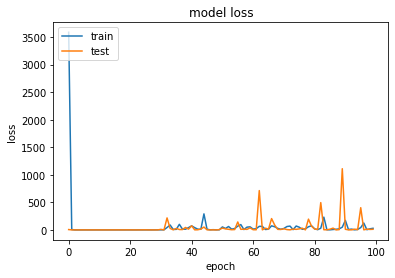

In [ ]:
# 绘制 loss和 val_loss 的收敛情况
# 大致在前20个epoch，mse就已经收敛到最小 （0.3左右）
plt.plot(history.history['loss'][:100])
plt.plot(history.history['val_loss'][:100])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

可以发现，模型是收敛速度是很快的，在大概epoch不到20的时候，训练集和测试集的MSE都降到最小（大约0.3左右）

* 测试

为了测试模型泛化能力以及鲁棒性，我挑选了同一个人（寡姐）的不同的三张照片。

虽然三张照片是同一个人，但是照片的风格差异较大。如果三张照片颜值预测结果差异较大，说明线性模型对于颜值预测的鲁棒性并不高。

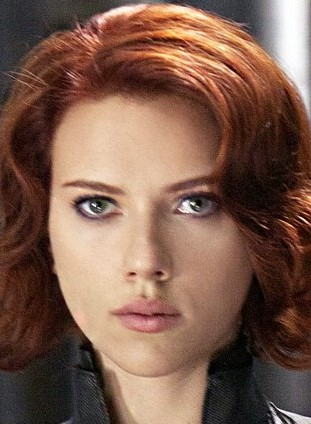

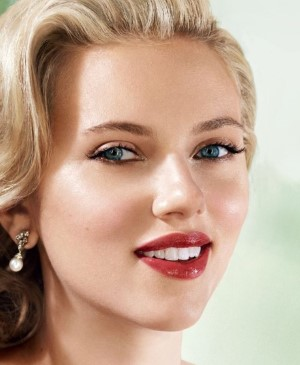

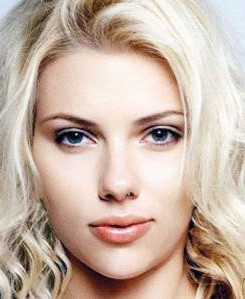

In [ ]:
import keras

def test_pre_process(test):
    # 测试图片的预处理，需要进行尺度的缩放（1*350*350*3）并归一化，
    test = cv.resize(test, (N,N), interpolation=cv.INTER_CUBIC)       
    test = test / 255              
    test = test[np.newaxis,...] 
    return test

# 加载val_loss最小的模型
model = keras.models.load_model('weights.best.hdf5')

# 读取测试图
test1 = cv.imread("course7/Scarlett_Johansson-1.jpg").astype(np.float32)
test2 = cv.imread("course7/Scarlett_Johansson-2.jpg").astype(np.float32)
test3 = cv.imread("course7/Scarlett_Johansson-3.jpg").astype(np.float32)

#展示测试图
cv2_imshow(test1)
cv2_imshow(test2)
cv2_imshow(test3)

test1 = test_pre_process(test1)
test2 = test_pre_process(test2)
test3 = test_pre_process(test3)

In [ ]:
print(model.predict(test1)[0][0])
print(model.predict(test2)[0][0])
print(model.predict(test3)[0][0])

1.3947695
2.5931938
3.6751606


从模型预测结果来看，确实不具有很高的鲁棒性和泛化能力。虽然寡姐很漂亮，但是她的颜值预测分数并不高。
另一方面对于同一个人，三张图片的预测结果差异很大（1.39到3.67），说明模型结果受照片风格影响严重。

### 五、总结

对于颜值预测这一回归问题，我们可以建立线性回归模型对颜值高低进行预测。但是由于线性模型结构简单，并不能在这一任务上达到很好的效果，预测结构受到照片风格等无关因素影响较大。

我们可以在之后建立更加复杂的神经网络模型。或者在数据处理时，对照片风格进行随机处理，扩充数据集，提高模型的泛化能力。